## Final Notebook - Hotel Customer Reviews Analysis

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import wrangle
import topic_modeling
import unicodedata
from nltk.corpus import stopwords

plt.rc('figure', figsize=(10, 7))
plt.style.use('fivethirtyeight')

### Project Overview:

- As the data science team at Booking.com we analyzed the extensive customer review dataset for our partner hotels in the European region. Using natural language processing, sentiment analysis, and topic modeling we were able to identify key groups within the body of customers and key topic drivers of reviewer’s score. With the reviewers’ scores, we calculated a Net Promoter Score-styled metric for each hotel helping them understand their customer’s opinions so they can implement improvements based on the insights gleaned from our review analysis.


### Project Goals:

- The goal of this project it to provide actionable recommendations to our partner hotels on how to increase their performance ratings based on our analysis of their customer review data.


### Data Acquisition:

- The dataset, containing 515,738 customer reviews and scores for 1493 luxury hotels across Europe, was found on kaggle (originally scraped from Booking.com). A data dictionary can be found within the README.md.


### Data Wrangling:

- This project required extensive data cleaning and wrangling including:

    - changing the column names to all lower case
    
    - parsing the list of strings in the tags column into separate feature columns
    
    - changing the data type of the timestamp column and engineering additional features containing portions of the overall time stamp
    
    - verifying and updating review word counts
    
    - parsing the address values and creating separate features for country, city, etc.
    
    - dropping unneeded columns
    
    - preparing the text data from NLP including basic clean, removing stopwords, and lemmatizing
    
    - changing the order of the columns within the dataframe 
    
    - cache the wrangled data as a json to reduce processing time during exploration


In [2]:
#pull in the cleaned and wrangled dataset using the wrangle_hotel function
df = wrangle.wrangle_hotel(use_cache=True)
#view the first three rows of the dataframe
df.head(3)

Using cached file...


,review_date,month_name,month,year,day_name,day,quarter,hotel_name,street,city,...,pos_sentiment_score,review_total_positive_word_counts,positive_unique_word_count,pos_lem_sentiment_score,negative_review,negative_clean_review,negative_lemma,positive_review,positive_clean_review,positive_lemma
0,2015-08-04T00:00:00.000Z,August,8,2015,Tuesday,4,3,Hilton London Metropole,225 Edgware Road Westminster Borough,London,...,0.4019,8,6,0.4019,First day the swimming pool was not opened th...,first day swimming pool opened therefore could...,first day swimming pool opened therefore could...,The hotel was clean and accessible,hotel clean accessible,hotel clean accessible
1,2015-08-04T00:00:00.000Z,August,8,2015,Tuesday,4,3,Hotel Mademoiselle,7 Rue des Petits H tels 10th,Paris,...,0.7906,7,6,0.7906,No Negative,,,very good location breakfast was great,good location breakfast great,good location breakfast great
2,2015-08-04T00:00:00.000Z,August,8,2015,Tuesday,4,3,Vienna Marriott Hotel,Parkring 12a 01 Innere Stadt,Vienna,...,0.7579,7,6,0.7579,Nothing,,,It was very nice excellent hotel,nice excellent hotel,nice excellent hotel


---

### Exploration - Who are our Customers?

- The initial exploration of the dataset consisted of reviewing the distribution of customers across key groupings including trip type, group type and nights stayed as well as looking at reviewer score distributions and average hotel score distributions

Text(0.5, 0, 'Percentage of customers')

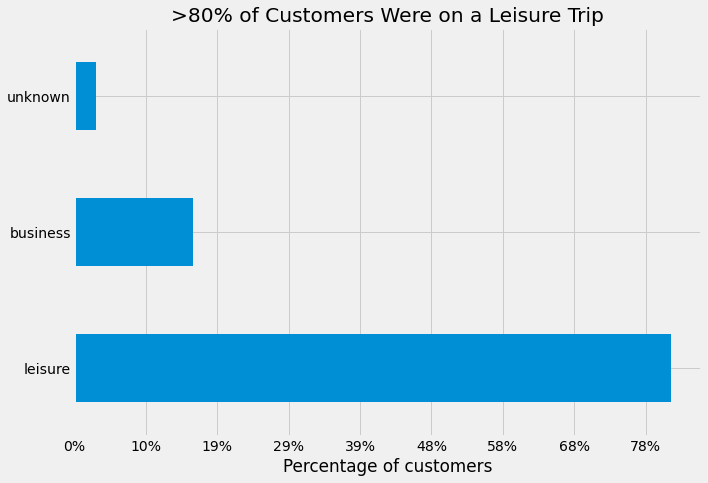

In [8]:
import matplotlib.ticker as mtick

#visualize the count of customers by trip type
ax = df.trip_type.value_counts().plot.barh()
# set x-axis to percentages
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df)))
plt.title('>80% of Customers Were on a Leisure Trip')
# label x-axis
plt.xlabel('Percentage of customers')


#### Key Takeaways:

Looking at the chart above, 81% of the customers who gave a review were on a leisure trip. Understanding the purpose of the customers stay can help the hotel to cater to the needs of customers most likely to give a review. 

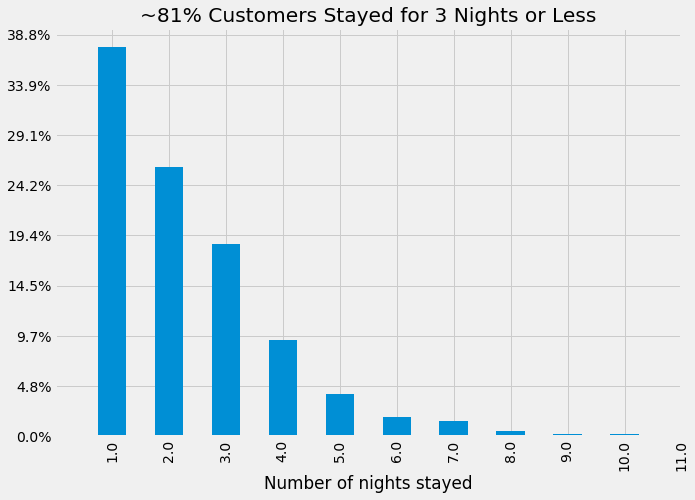

In [14]:
#visualize the number of customers by number of nights stayed
ax = df.nights_stayed.value_counts().plot.bar()
# set y-axis to percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df)))
plt.title('~81% of Customers Stayed for 3 Nights or Less')
plt.xlim(-1, 10)
# label x-axis
plt.xlabel('Number of nights stayed')
plt.show()

Key Takeaways:

- 37.5% of customers stayed one night
- 25.9% of customers stayed two nights
- 18.5% of customers stayed three nights
- 9.2% of customers stayed four nights
- 8.9% of customers stayed over four nights


~ 81% of the customers who gave a review stayed at a hotel for less than three nights. Where ~19% of guests stay at a hotel for greater than 3 nights. This gives the hotel approximatly three nights to improve the the majority of customers experience for an increase in review score.

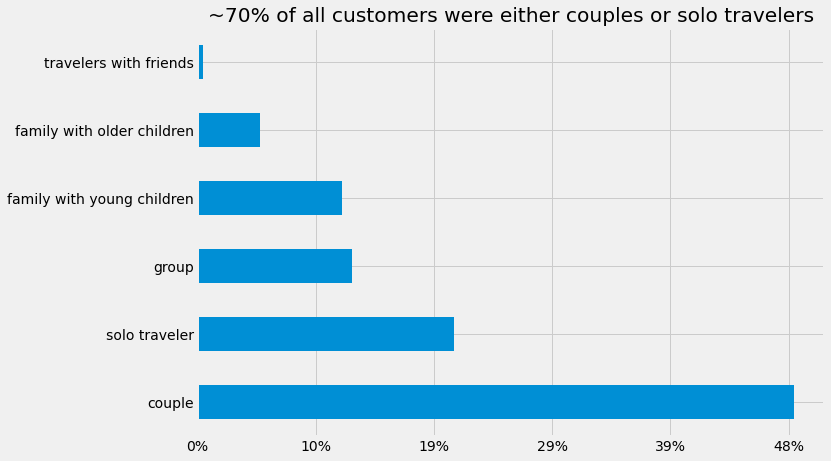

In [7]:
#visualize the number of customers by group type
ax = df.group_type.value_counts().plot.barh()
# set x-axis to percentages
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=len(df)))
plt.title('~70% of all customers were either couples or solo travelers')
plt.show()

Key Takeaways:
- 48.9% of customers who gave a review were a couple.
- 21% of customers who gave a review were solo travelers.
- 12.6% of customers who gave a review were a group.
- 11.8% of customers who gave a review were a family with young children.


The majority of customers who gave a review were couples at 48.9% of all reviews. Followed by solo travelers at 21% of all reviews. 69.9% of all reviews were in parties of two people or less. With ~ 30% of customers who gave a review in a party greater than two people.

---

## Exploration - What is the distribution of the Reviewer Scores?

The distribution of reviewer scores in this dataset indicates a trend toward score inflation.

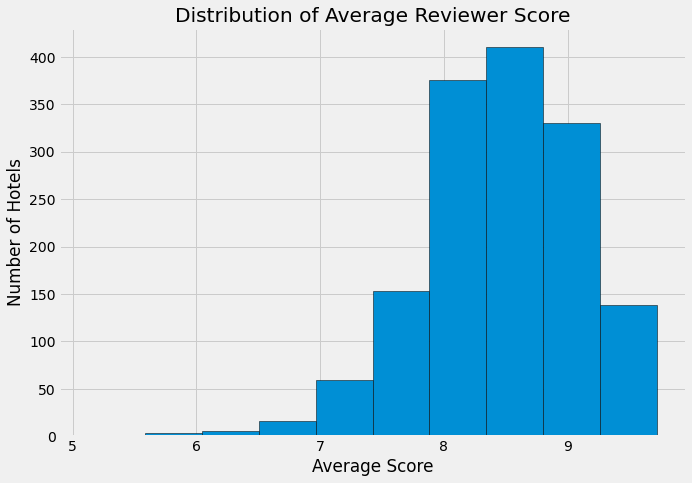

In [6]:
#visualize the distribution of average reviewer score
df.groupby('hotel_name').reviewer_score.mean().plot.hist(ec= 'black')
plt.title('Distribution of Average Reviewer Score')
plt.xlabel('Average Score')
plt.ylabel('Number of Hotels')
# add average score line
plt.show()

Key Takeaways:

The distribution of the reviewer score is skewed to the left. Where the average reviewer score is around 8.4. The lowest reviewer score is 5.12 and the highest reviewer score is 9.73.


In [7]:
#summary stats for reviewer scores
df.reviewer_score.describe()

count    515738.000000
mean          8.395077
std           1.637856
min           2.500000
25%           7.500000
50%           8.800000
75%           9.600000
max          10.000000
Name: reviewer_score, dtype: float64

In [17]:
def hotel_data():
    """Function takes in a Hotel Name 
    and returns the rolling average of the 
    reviewer score and the number of reviews.
    """
    # combine the 'month', 'year', and 'day' columns into a single column called 'date'
    df['date'] = df['month'].astype(str) + '/' + df['day'].astype(str) + '/' + df['year'].astype(str)
    # create datetime with date column
    df['date'] = pd.to_datetime(df['date'])
    # set date as datetime index
    df.set_index('date', inplace=True)
    # hotel_name = 'Intercontinental London The O2'
    # hotel_df = df[df.hotel_name == hotel_name]
    hotel_df = df.resample('W').mean().assign(
    rolling_30=lambda df: df.reviewer_score.rolling(4).mean(),
    rolling_60=lambda df: df.reviewer_score.rolling(8).mean(),
    rolling_90=lambda df: df.reviewer_score.rolling(12).mean(),
    )
    # create one plot for all three rolling averages
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    ax.plot(hotel_df.rolling_30, label='30-day rolling average')
    ax.plot(hotel_df.rolling_60, label='60-day rolling average')
    ax.plot(hotel_df.rolling_90, label='90-day rolling average')
    ax.set_title('Rolling averages of reviewer score for\n Luxury Hotels')
    ax.set_ylabel('reviewer score')
    ax.lines[0].set_linewidth(4)
    ax.lines[1].set_linewidth(4)
    ax.lines[2].set_linewidth(4)
    for label in ax.xaxis.get_ticklabels():
        label.set_fontsize(15)
    ax.tick_params(axis='x', rotation=30)
    ax.legend()

    # create a plot for the rolling aver of number of reviews
    hotel_df = df.resample('W').mean().assign(
    rolling_30=lambda df: df.total_number_of_reviews.rolling(4).mean(),
    rolling_60=lambda df: df.total_number_of_reviews.rolling(8).mean(),
    rolling_90=lambda df: df.total_number_of_reviews.rolling(12).mean(),
    )
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    ax.plot(hotel_df.rolling_30, label='30-day rolling average')
    ax.plot(hotel_df.rolling_60, label='60-day rolling average')
    ax.plot(hotel_df.rolling_90, label='90-day rolling average')
    ax.set_title('Rolling averages of total number of reviews for \n Luxury Hotels')
    ax.set_ylabel('Total number of reviews')
    ax.lines[0].set_linewidth(4)
    ax.lines[1].set_linewidth(4)
    ax.lines[2].set_linewidth(4)
    for label in ax.xaxis.get_ticklabels():
        label.set_fontsize(15)
    ax.tick_params(axis='x', rotation=30)
    ax.legend()
    plt.show()
    return

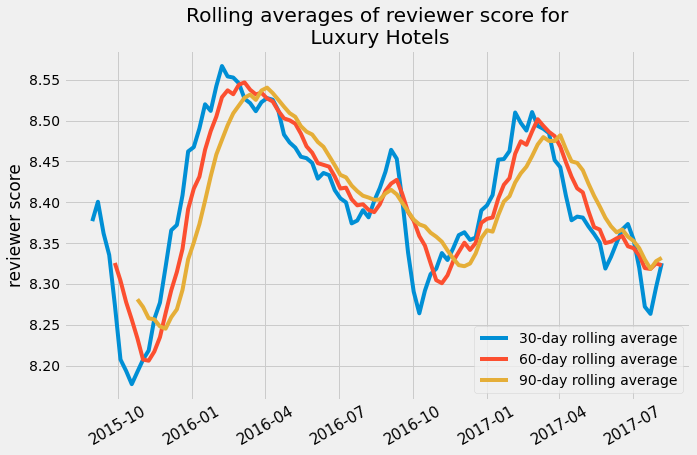

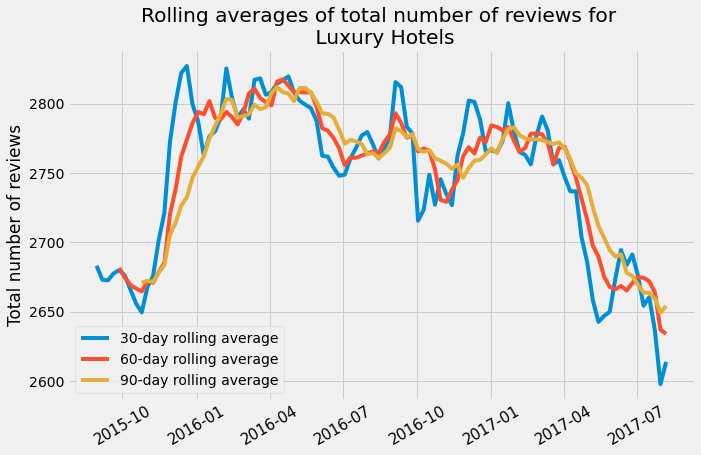

In [18]:
hotel_data()

Key Takeaways:

The data shows that between July to December(end of the year/Holiday season) guests tend to score hotels lower than average, while from January to June guests tend to score hotels higher than average. There is a slight decline in the number of customer reviews as the year progresses.

---

### Exploration - Promoter Scores:

- Promoter scores use reviewer's scores between 0 and 10 to classify each reviewer as either a 'promoter' (score of 9 or 10), a 'passive' (score of 7 or 8), or a 'detractor' (score of 6 or below).

- The promoter score for a hotel is calculted by taking the number of promoters minus the number of detractors divided by the total number of reviewers

In [19]:
def hotel_nps_score(series):
    '''
    This function takes in a sereis from the nps_group column and calculates the promoter score by
    taking the count of promoters minus the count of detractors and dividing it by the total number
    of reviewers
    '''
    score = ((series == 'promoter').sum() - (series == 'detractor').sum()) / series.size
    score = round(score * 100)
    return score

In [20]:
#calculate promoter scores for each hotel
hotel_df = pd.DataFrame(df.groupby(df.hotel_name).nps_group.apply(hotel_nps_score))
#rename the resulting score column as 'promoter score'
hotel_df = hotel_df.rename(columns={'nps_group':'promoter_score'})
#sort the values in decending order and show the truncated results
hotel_df.sort_values(by='promoter_score', ascending=False)

,promoter_score
hotel_name,
H10 Casa Mimosa 4 Sup,93
Ritz Paris,93
Hotel Casa Camper,93
The Soho Hotel,92
Bulgari Hotel London,92
...,...
Villa Eugenie,-52
Kube Hotel Ice Bar,-53
Savoy Hotel Amsterdam,-56


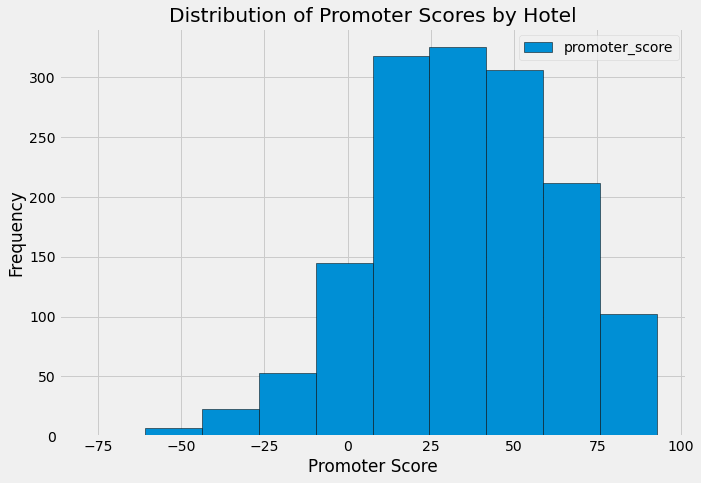

In [21]:
#Distribution of hotel promoter scores
hotel_df.plot.hist(ec='black')
plt.title('Distribution of Promoter Scores by Hotel')
plt.xlabel('Promoter Score')
plt.show()

Key Takeaways:

The average promoter score is 34.
The minimum promoter score is -78.
The maximum promoter score is 93. 

The promoter score is a Net Promoter Score-styled metric we used to better gauge hotel performance. By binning the scores (Detractors, Passives, and Promoters) based on raw reviewer scores, and using the formula $(promoters-detractors)/(detractors + passives + promoters)$, we mitigate the inflation observed in those raw reviewer scores, thus achieving more accurate insight into hotel customer service performance.

In [13]:
# average promoter score in hotel_df
hotel_df.promoter_score.describe()

count    1492.000000
mean       34.391421
std        27.524849
min       -78.000000
25%        16.000000
50%        35.000000
75%        55.000000
max        93.000000
Name: promoter_score, dtype: float64

---

## Exploration - Natural Language Processing

- After cleaning / wrangling the text data from the reviews we looked at most frequent unigrams, bigrams, trigram, etc from both the positive reviews and the negative reviews. 

In [14]:
#join all the positive review text into one string
pos_reviews = ' '.join(df.positive_clean_review)
#split the string on whitespaces so word count/comparisond can be made
pos_reviews = pos_reviews.split()
#join all the negative review text into one string
neg_reviews = ' '.join(df.negative_clean_review) 
#split the string on whitespaces so word count/comparisond can be made
neg_reviews = neg_reviews.split()

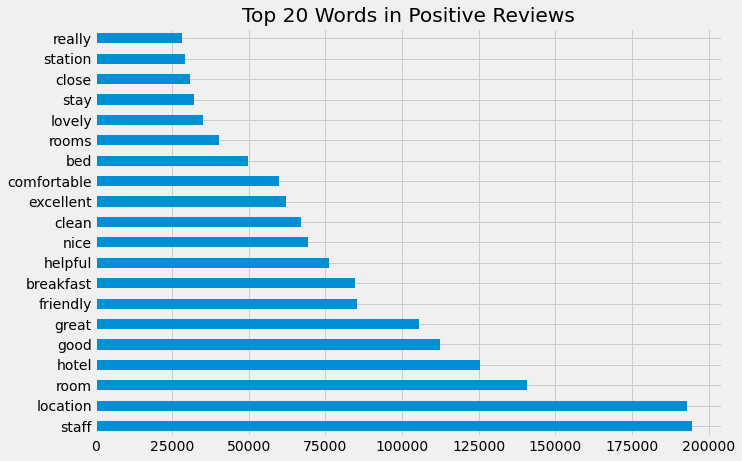

In [15]:
#visualize the top 20 unigrams in the positive reviews
pd.Series(pos_reviews).value_counts().head(20).plot.barh()
plt.title('Top 20 Words in Positive Reviews')
plt.show()

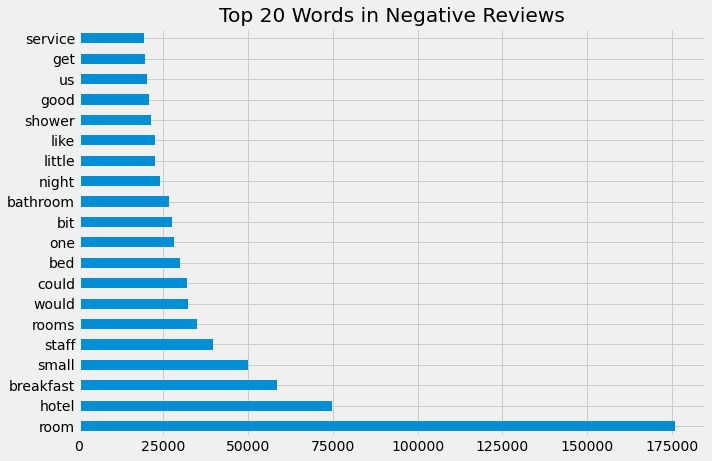

In [16]:
#visualize the top 20 words in the negative reviews
pd.Series(neg_reviews).value_counts().head(20).plot.barh()
plt.title('Top 20 Words in Negative Reviews')
plt.show()

In [18]:
#top 20 positive review trigrams
pos_trigrams = (pd.Series(nltk.ngrams(pos_reviews, 3)).value_counts().head(20))
pos_trigrams.head(20)

(staff, friendly, helpful)     9667
(friendly, helpful, staff)     7191
(location, friendly, staff)    4081
(staff, helpful, friendly)     3189
(staff, great, location)       3170
(hotel, great, location)       2777
(good, value, money)           2553
(within, walking, distance)    2403
(friendly, staff, good)        2080
(would, definitely, stay)      2049
(staff, good, location)        2019
(friendly, staff, great)       2008
(helpful, friendly, staff)     1977
(staff, extremely, helpful)    1960
(great, location, friendly)    1760
(nothing, much, trouble)       1639
(hotel, good, location)        1561
(location, great, staff)       1524
(location, great, location)    1500
(location, staff, friendly)    1455
dtype: int64

In [19]:
#top 20 negative review trigrams
neg_trigrams = (pd.Series(nltk.ngrams(neg_reviews, 3)).value_counts().head(20))
neg_trigrams.head(20)

(4, star, hotel)                1915
(room, bit, small)              1171
(room, little, small)            907
(tea, coffee, making)            892
(5, star, hotel)                 874
(coffee, making, facilities)     873
(making, facilities, room)       769
(room, quite, small)             768
(tea, coffee, facilities)        655
(two, single, beds)              650
(breakfast, included, price)     596
(breakfast, could, better)       535
(4, stars, hotel)                507
(beds, pushed, together)         503
(front, desk, staff)             490
(four, star, hotel)              489
(tea, coffee, room)              485
(far, city, center)              475
(tea, making, facilities)        444
(air, conditioning, room)        442
dtype: int64

---

## Sentiment Intensity Analysis

#### Sentiment Intensity scores are, in essence, calculated by the use of a comparison to a dictionary of positive and negative words. 
The scores range from -1 to 1, -1 being the most negative, and 1 being the most positive.

- Notable trends were found in the average sentiment intensity scores for trip type ('leisure', 'business', 'unknown') and group type ('couple', 'solo traveler', 'group', 'family with young children', 'family with older children', 'travelers with friends').
- Leisure travelers' average sentiment intensity scores were higher than those of the other two trip types.
- Solo travelers and families with young children tended to have lower average sentiment intensity scores than the other groups.
- Sentiment scores for negative reviews were muted in comparison to scores for positive reviews.
- Among the Net Promoter Score groups ('Detractor', 'Passive', 'Promoter'), of note is the 'Passive' group, whose average scores were higher than the other groups on negative reviews.


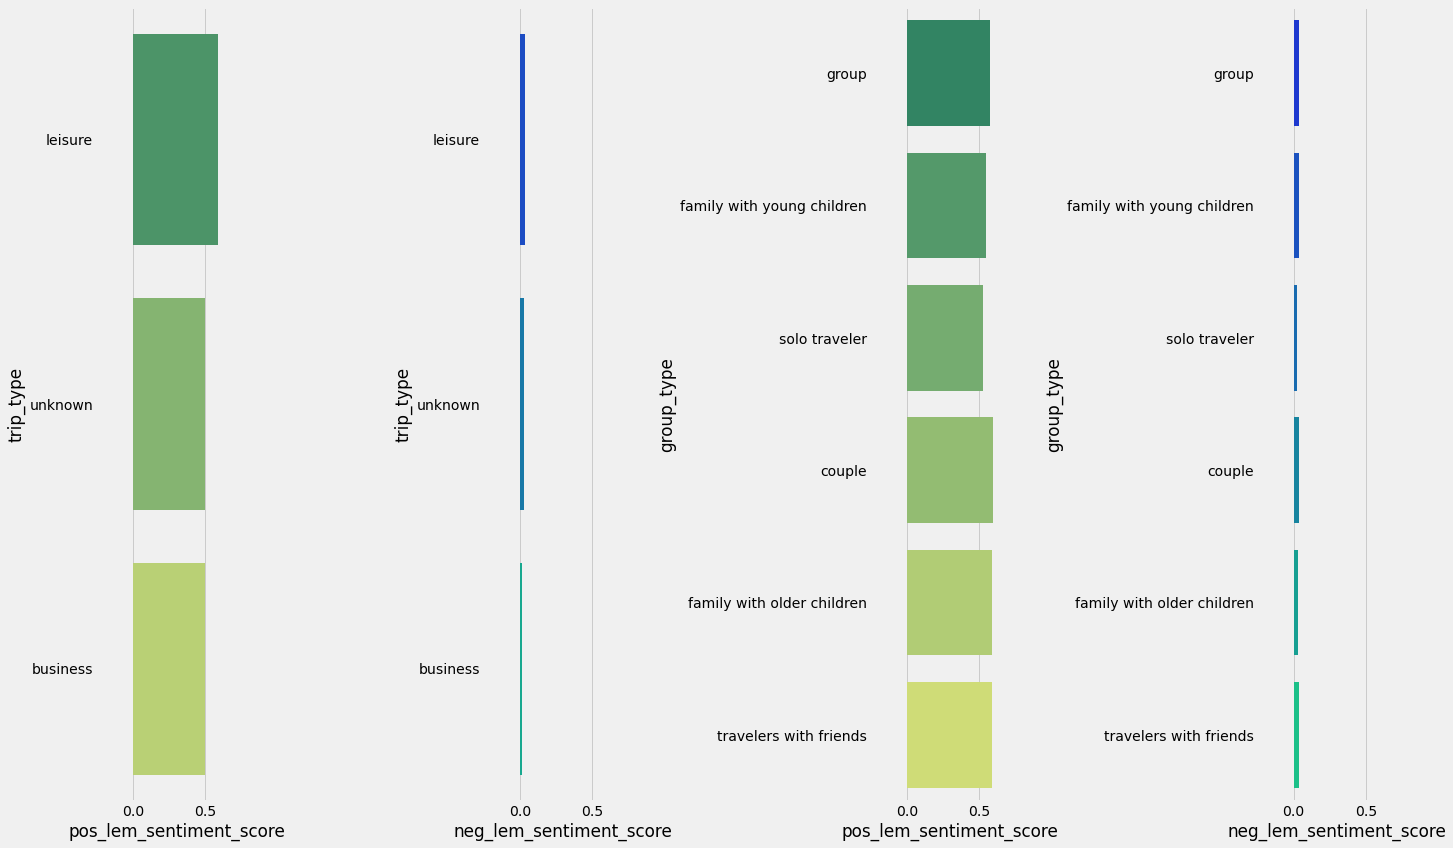

In [20]:
plt.figure(figsize=(20,12))

plt.subplot(141)
plt.xlim(-.25, .85)
sns.barplot(data=df, y= 'trip_type', x= 'pos_lem_sentiment_score', ci=False, palette='summer')
#plt.show()

#Compare group type and positive sentiment score
plt.subplot(143)
plt.xlim(-.25, .85)
sns.barplot(data=df, y= 'group_type', x= 'pos_lem_sentiment_score', ci= False, palette='summer')

# Show tags (trip and group type) against negative sentiment score

plt.subplot(142)
plt.xlim(-.25, .85)
sns.barplot(data=df, y= 'trip_type', x= 'neg_lem_sentiment_score', ci=False, palette='winter')

plt.subplot(144)
plt.xlim(-.25, .85)
sns.barplot(data=df, y= 'group_type', x= 'neg_lem_sentiment_score', ci= False, palette='winter')
#plt.xticks(rotation=90)
plt.tight_layout()

<AxesSubplot:xlabel='nps_group', ylabel='neg_lem_sentiment_score'>

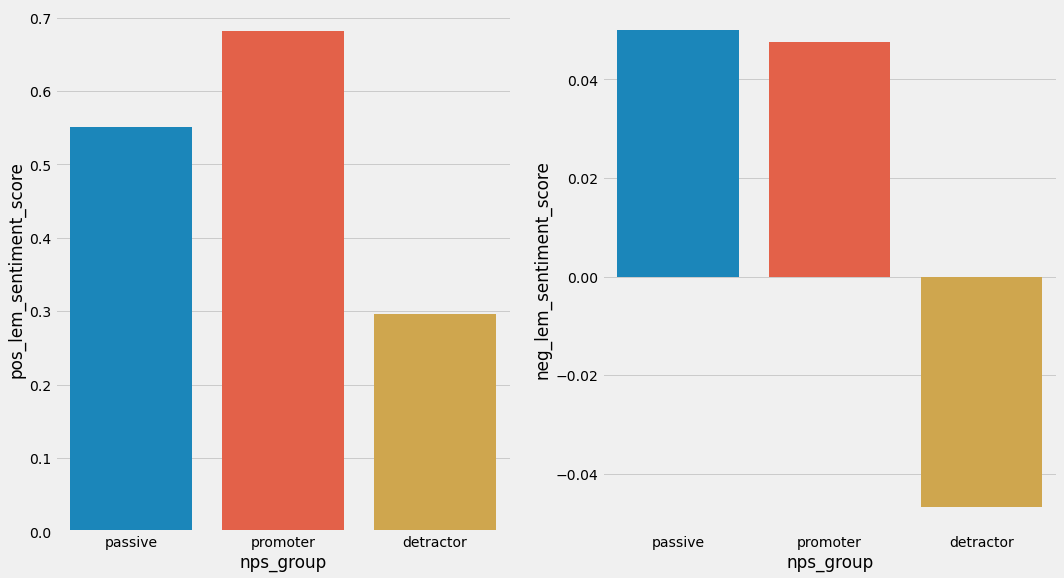

In [21]:
#Compare NPS group and positive sentiment score
plt.figure(figsize=(16,9))

plt.subplot(121)
sns.barplot(data=df, x='nps_group', y='pos_lem_sentiment_score', ci=False)

#Compare NPS group and negative sentiment score
plt.subplot(122)
sns.barplot(data=df, x='nps_group', y='neg_lem_sentiment_score', ci=False)


## Topic Modeling 

- For Topic Modeling we used sklearn's Latent Dirichlet Allocation (LDA) model. The LDA model takes each word in the document and assigns it to one of k topics. k is the number of topics set as a hyperparameter in the creation of the LDA model. The model then calculates the proportion of words in the document that are assigned to each topic or p(topic|document). It then calculates the proportion of documents assigned to each topic because of the words in the document or p(word|topic). 

- Pragmatically our process consisted of using the sklearn Count Vectorizer to produce a sparse matrix of token counts from each collection of positive and negative reviews. This sparse matrix was then used as the input for the LDA model and through some data wrangle of the model output we were able to find the top topic for each document as well as the top 15 words for each topic.

- After completing the topic modeling process the resulting dominant topic values for both the positive and negative reviews were saved as a csv and loaded into the notebook. A new categorical feature column was added to the dataframe that denotes the dominant topic for that review.

- The top 15 key words for each of the 10 topic groups for both the negative and positive reviews can be seen below. These key words are paired with the most frequent dominant topic in the hotel specific dataset seen later in this notebook

In [22]:
positive_dominant_topics, positive_keywords, negative_dominant_topics, negative_keywords = topic_modeling.acquire_topics(df.positive_lemma, df.negative_lemma)

#rename the columns for further analysis with pandas
positive_dominant_topics.rename(columns={'0':'positive_dominant_topic'}, inplace=True)
negative_dominant_topics.rename(columns={'0':'negative_dominant_topic'}, inplace=True)
#reset the index of the original dataframe
df = df.reset_index()

Using cached csv file...


In [23]:
#concatenate the positive and negative dominant topics onto the original dataframe as new categorical columns
df = pd.concat([df, positive_dominant_topics.positive_dominant_topic, negative_dominant_topics.negative_dominant_topic], axis=1)
df.head(3)

,date,review_date,month_name,month,year,day_name,day,quarter,hotel_name,street,...,positive_unique_word_count,pos_lem_sentiment_score,negative_review,negative_clean_review,negative_lemma,positive_review,positive_clean_review,positive_lemma,positive_dominant_topic,negative_dominant_topic
0,2015-08-04,2015-08-04T00:00:00.000Z,August,8,2015,Tuesday,4,3,Hilton London Metropole,225 Edgware Road Westminster Borough,...,6,0.4019,First day the swimming pool was not opened th...,first day swimming pool opened therefore could...,first day swimming pool opened therefore could...,The hotel was clean and accessible,hotel clean accessible,hotel clean accessible,0,2
1,2015-08-04,2015-08-04T00:00:00.000Z,August,8,2015,Tuesday,4,3,Hotel Mademoiselle,7 Rue des Petits H tels 10th,...,6,0.7906,No Negative,,,very good location breakfast was great,good location breakfast great,good location breakfast great,2,0
2,2015-08-04,2015-08-04T00:00:00.000Z,August,8,2015,Tuesday,4,3,Vienna Marriott Hotel,Parkring 12a 01 Innere Stadt,...,6,0.7579,Nothing,,,It was very nice excellent hotel,nice excellent hotel,nice excellent hotel,0,0


In [24]:
#view the positive keywords by topic
positive_keywords

,Unnamed: 0,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
0,Topic 0,hotel great location,staff great location,room clean comfortable,hotel good location,room spacious clean,good location close,room comfy bed,helpful staff great,great location staff,good location friendly,staff excellent location,breakfast friendly staff,comfortable staff friendly,great location clean,good staff friendly
1,Topic 1,staff helpful friendly,staff good location,staff really helpful,staff extremely friendly,clean comfortable room,great location close,staff friendly room,location helpful staff,helpful staff good,staff super friendly,comfortable bed good,bed extremely comfortable,great location good,good size room,staff nice helpful
2,Topic 2,staff friendly helpful,staff extremely helpful,room comfortable bed,room good size,friendly helpful room,location great staff,hotel staff friendly,friendly staff clean,close metro station,staff good breakfast,bed really comfortable,location staff friendly,close tube station,easy walking distance,bed comfortable staff
3,Topic 3,friendly helpful staff,good value money,friendly staff good,room friendly staff,location walking distance,clean staff friendly,location friendly helpful,bed super comfy,room good breakfast,great location nice,bed comfy room,breakfast good location,location good breakfast,comfy bed great,excellent value money
4,Topic 4,location friendly staff,helpful friendly staff,great location friendly,friendly staff great,staff really friendly,bed comfortable room,great value money,great location great,hotel friendly staff,location minute walk,room great location,location excellent staff,bed really comfy,staff polite helpful,really friendly helpful


In [25]:
#view the negative keywords by topic
negative_keywords

,Unnamed: 0,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
0,Topic 0,air conditioning working,room air conditioning,room double bed,took long time,double bed single,room hot air,size room small,coffee machine room,bed single bed,booking com hotel,room small price,single room small,breakfast room small,bottle water room,asked quiet room
1,Topic 1,room little small,breakfast included price,air conditioning work,room little bit,room service menu,room size small,mini bar room,good night sleep,little bit small,small room small,little bit far,bed bit hard,iron ironing board,room booking com,double room small
2,Topic 2,tea coffee facility,coffee facility room,room small bed,room really small,room ground floor,breakfast included room,room smaller expected,poor value money,water pressure shower,ground floor room,non smoking room,hotel booking com,included room rate,small room bathroom,room far small
3,Topic 3,room bit small,coffee making facility,making facility room,tea coffee making,tea coffee room,tea making facility,room extremely small,room small bathroom,good value money,room service food,single bed pushed,room single bed,booked double room,location bit far,like star hotel
4,Topic 4,room quite small,air conditioning room,far city center,booked booking com,air conditioning unit,king size bed,far city centre,room small room,bed little hard,bit far city,hot water shower,booking booking com,room bathroom small,free wifi room,room small people


---

## Exploration of Drivers of Reviewer Score by Key Customer Group

#### Group Type = Couples:

- The majority of group type represented in this dataset was couples. Breakdown of dominant topics and keywords for this subgroup is seen below

In [26]:
#subset the dataframe to represent only reviews from group types that were couples
couples = df[df['group_type'] == 'couple']
#view the counts based on nps group
couples.nps_group.value_counts()

promoter     128840
passive       85754
detractor     37700
Name: nps_group, dtype: int64

In [27]:
#further subset the dataframe by the observations that were couples and detractors
detractor_couples = couples[couples['nps_group'] == 'detractor']
#show the top three negative dominant topics
detractor_couples.negative_dominant_topic.value_counts().head(3)

0    22702
1     4292
2     4236
Name: negative_dominant_topic, dtype: int64

#### Key Findings:
   - 37,000 couples provided a reviewer score of less than 7 making them a detractor
   
   - The top three negative review topics wer topics 0, 1, and 2
   
   - Keywords/themes from those topic groups include - 

---

#### Trip Type = Leisure Trip:

- The majority of trip type represented in this dataset was leisure trips. Breakdown of dominant topics and keywords for this subgroup is seen below

In [28]:
leisure_trip = df[df['trip_type'] == 'leisure']
leisure_trip.nps_group.value_counts()

promoter     209906
passive      144380
detractor     63492
Name: nps_group, dtype: int64

In [29]:
detractor_leisure = leisure_trip[leisure_trip['nps_group'] == 'detractor']
detractor_leisure.negative_dominant_topic.value_counts().head(3)

0    38952
1     7146
2     6867
Name: negative_dominant_topic, dtype: int64

#### Key Findings:
   - 63,492 leisure trip customers provided a reviewer score of less than 7 making them a detractor
   
   - The top three negative review topics were topics 0, 1, and 2
   
   - Keywords/themes from those topic groups include - 

---

#### Nights Stayed = 4 or less

- Most customers in this dataset stayed four or less nights

In [31]:
threel_night = df[df['nights_stayed'] <= 3]
threel_night.nps_group.value_counts()

promoter     204456
passive      147821
detractor     71126
Name: nps_group, dtype: int64

In [32]:
threel_detractor = threel_night[threel_night['nps_group'] == 'detractor']
threel_detractor.negative_dominant_topic.value_counts().head(3)

0    44191
1     7838
2     7521
Name: negative_dominant_topic, dtype: int64

#### Key Findings:

- Notes

---

### Hotel Specific Data Breakdown:

- As an additional resource to our partner hotels we are providing hotel specific information from our analysis

- The dataframe below has promoter score, average positive and negative sentiment scores, main topics and key words from positive reviews and main topisc and key words from negative reviews.

In [36]:
#Avg sentiment score of positive feedback by hotel
pos_sent = pd.DataFrame(df.groupby(df.hotel_name).pos_lem_sentiment_score.mean())
#avg sentiment score for negative feedback by hotel
neg_sent = pd.DataFrame(df.groupby(df.hotel_name).neg_lem_sentiment_score.mean())
#count of nps_group values
nps_type = pd.DataFrame(df.groupby(df.hotel_name).nps_group.value_counts()).unstack()
#pull top neg dominant topic by hotel
neg_dom_top = pd.DataFrame(df.groupby(df.hotel_name).negative_dominant_topic.agg(lambda hotel_topics: hotel_topics.value_counts().head(1).index))
#pull top pos dominant topic by hotel
pos_dom_top = pd.DataFrame(df.groupby(df.hotel_name).positive_dominant_topic.agg(lambda hotel_topics: hotel_topics.value_counts().head(1).index))
#concat the dfs
hotels = pd.concat([hotel_df, nps_type.nps_group.detractor, nps_type.nps_group.passive, nps_type.nps_group.promoter,
                    pos_sent.pos_lem_sentiment_score, neg_sent.neg_lem_sentiment_score, neg_dom_top.negative_dominant_topic,
                   pos_dom_top.positive_dominant_topic], axis=1)
hotels = hotels.reset_index()
#concat the keywords
cols = ['Word 0', 'Word 1', 'Word 2', 'Word 3', 'Word 4', 'Word 5', 'Word 6', 'Word 7', 'Word 8', 'Word 9', 'Word 10', 'Word 11', 'Word 12', 'Word 13', 'Word 14']
n_words = pd.DataFrame(negative_keywords[cols].apply(lambda row: ', '.join(row.values.astype(str)), axis=1))
p_words = pd.DataFrame(positive_keywords[cols].apply(lambda row: ', '.join(row.values.astype(str)), axis=1))
#clean and merge with hotels df
n_words = n_words.reset_index()
n_words.rename(columns={0:'negative_keywords', 'index':'n_grp'}, inplace=True)
p_words = p_words.reset_index()
p_words.rename(columns={0:'positive_keywords', 'index':'p_grp'}, inplace=True)
hotels = hotels.merge(n_words, how='left', left_on='negative_dominant_topic', right_on='n_grp')
hotels = hotels.merge(p_words, how='left', left_on='positive_dominant_topic', right_on='p_grp')
hotels = hotels.drop(columns={'n_grp', 'p_grp'})
hotels = hotels.set_index('hotel_name')
hotels.rename(columns={'pos_lem_sentiment_score':'average_pos_sentiment_score', 'neg_lem_sentiment_score':'average_neg_sentiment_score'}, inplace=True)
hotels.head()

,promoter_score,detractor,passive,promoter,average_pos_sentiment_score,average_neg_sentiment_score,negative_dominant_topic,positive_dominant_topic,negative_keywords,positive_keywords
hotel_name,,,,,,,,,,
11 Cadogan Gardens,53,16.0,42.0,101.0,0.605062,0.010621,0,0,"air conditioning working, room air conditionin...","hotel great location, staff great location, ro..."
1K Hotel,9,34.0,66.0,48.0,0.543749,0.008590,0,0,"air conditioning working, room air conditionin...","hotel great location, staff great location, ro..."
25hours Hotel beim MuseumsQuartier,56,47.0,208.0,434.0,0.653845,0.048747,0,0,"air conditioning working, room air conditionin...","hotel great location, staff great location, ro..."
41,91,2.0,5.0,96.0,0.685737,0.039544,0,0,"air conditioning working, room air conditionin...","hotel great location, staff great location, ro..."
45 Park Lane Dorchester Collection,86,NaN,4.0,24.0,0.503500,0.074264,0,0,"air conditioning working, room air conditionin...","hotel great location, staff great location, ro..."


In [37]:
hotels.negative_dominant_topic.value_counts()

0    1492
Name: negative_dominant_topic, dtype: int64

In [38]:
hotels.positive_dominant_topic.value_counts()

0    1492
Name: positive_dominant_topic, dtype: int64

---

### Summary

Overall Findings:

   - 49% of all reviewers were couples
   
   - 81% of all reviewers were on a leisure trip
   
   - 95% of all reviewers stayed for five or less nights
   
   - Top 5 positive unigrams are - staff, location, room, hotel, good
   
   - Top 5 negative ungrams are - room, hotel, breakfast, small, staff
   
   - Top positive topic is - Topic 0 and Topic 4
   
   - Top negative topic is - Topic 0
    
Hotel Specific Findings:

   - The average hotel promoter score is 34
   
   - The max hotel promoter score is 93
    
   - The minimum hotel promoter score is -78
    

---

### Recommendations

- Each hotel should look over their individual information in the 'hotels' table.

- 'Topic 0 and Topic 4' were noted as overall primary positive topics and each hotel should focus on highlighting their room characteristics (large size, cleanliness, comfort, bathrooms/showers) and their friendly / helpful staff and location in marketing and customer interactions

- 'Topic 0' was noted as overall primary negative topic and each hotel should evaluate how staff issues, noise or disturbance outside, and room size affect their property

- If your hotel has an NPS score of higher than 50 you should focus on maintaining your performance in areas noted as 'primary positive topics' 

- If your hotel has an NPS score less than 50 you should focus on addressing issues noted as 'primary negative topics'